In [15]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt


import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the single DOF finite difference model
from mlp_singledof_rnn import MLP, MLPProjectionFilter, CustomGRULayer, GRU_Hidden_State, CustomLSTMLayer, LSTM_Hidden_State



/home/alinjar/simple_training_warm_start/RNN_training


In [16]:
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, inp, theta_init, v_start, v_goal):
        # input
        self.inp = inp 
        self.theta_init = theta_init
        self.v_start = v_start
        self.v_goal = v_goal

    def __len__(self):
        return len(self.inp)    

    def __getitem__(self, idx):
        # Input
        inp = self.inp[idx]
        theta_init = self.theta_init[idx]
        v_start = self.v_start[idx]
        v_goal = self.v_goal[idx]

        return (torch.tensor(inp).float(),
                torch.tensor(theta_init).float(),
                torch.tensor(v_start).float(),
                torch.tensor(v_goal).float())

In [17]:
def sample_uniform_trajectories(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng

In [18]:
# import argparse

# parser = argparse.ArgumentParser(description="Choose RNN module: LSTM or GRU")
# parser.add_argument("--rnn_module", type=str, default="LSTM", help="Choose RNN module: LSTM or GRU")
# args = parser.parse_args()

#Choose GRU or LSTM here

rnn = "GRU"
#rnn = "LSTM"

In [19]:
#Parameters for MLP model

num_batch = 1000
num_dof=1
num_steps=50
timestep=0.05
v_max=1.0
a_max=2.0
j_max=5.0
p_max=180.0*np.pi/180.0 
theta_init=0.0
maxiter_projection = 20
nvar_single = num_steps
nvar = num_dof * nvar_single
theta_init_min=0.0
theta_init_max=2*np.pi

In [20]:
#calculating number of constraints
num_acc = num_steps - 1
num_jerk = num_acc - 1
num_pos = num_steps
num_vel_constraints = 2 * num_steps * num_dof
num_acc_constraints = 2 * num_acc * num_dof
num_jerk_constraints = 2 * num_jerk * num_dof
num_pos_constraints = 2 * num_pos * num_dof
num_total_constraints = (num_vel_constraints + num_acc_constraints + 
                            num_jerk_constraints + num_pos_constraints)

##Maximum Iterations
maxiter_projection = 20

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

#### creating dataset

dataset_size = num_batch*4 #200000

theta_init, rng_theta_init = sample_uniform_trajectories(41, var_min= theta_init_min, var_max = theta_init_max, dataset_size=dataset_size, nvar=1)
#print("theta_init", theta_init.shape)
v_start, rng_v_start = sample_uniform_trajectories(40, var_min =-0.8*v_max, var_max = 0.8*v_max, dataset_size=dataset_size, nvar=1)
#print("v_start", v_start.shape)
v_goal, rng_v_goal = sample_uniform_trajectories(39, var_min =-0.8*v_max, var_max = 0.8*v_max, dataset_size=dataset_size, nvar=1)

#For training
xi_samples, rng = sample_uniform_trajectories(42, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

#For validation
xi_val, rng_val = sample_uniform_trajectories(43, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

# xi_samples = torch.from_numpy(xi_samples)
# xi_val = torch.from_numpy(xi_val)

inp = np.hstack(( xi_samples, theta_init, v_start, v_goal))

inp_val = np.hstack(( xi_val, theta_init, v_start, v_goal))

Using cuda device


In [22]:
# Using PyTorch Dataloader
train_dataset = TrajDataset(inp, theta_init, v_start, v_goal)
val_dataset = TrajDataset(inp_val, theta_init, v_start, v_goal)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)


In [23]:

if rnn == "GRU":
    print("Training with GRU")
    #GRU handling
    rnn = "GRU"
    gru_input_size = 3*num_total_constraints+3*nvar
    # print(gru_input_size)
    gru_hidden_size = 512
    # gru_output_size = (2*nvar)**2+2*nvar
    gru_output_size = num_total_constraints+nvar
    # gru_context_size = mlp_planner_inp_dim

    gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

    rnn_context = gru_context


    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = gru_hidden_size

    gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)
    
    rnn_init = gru_init
    ##
elif rnn == "LSTM":
    print("Training with LSTM")
    #LSTM handling
    rnn = "LSTM"
    lstm_input_size = 3*num_total_constraints+3*nvar
    # print(lstm_input_size)
    lstm_hidden_size = 512
    # lstm_output_size = (2*nvar)**2+2*nvar
    lstm_output_size = num_total_constraints+nvar
    # lstm_context_size = mlp_planner_inp_dim

    lstm_context = CustomLSTMLayer(lstm_input_size, lstm_hidden_size, lstm_output_size)

    rnn_context = lstm_context

    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = lstm_hidden_size

    lstm_init = LSTM_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

    rnn_init = lstm_init

    ##

##


Training with GRU


In [24]:

enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints #( xi_samples- 0:nvar, lamda_smples- nvar:2*nvar)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)

In [25]:


model = MLPProjectionFilter(mlp=mlp,rnn_context=rnn_context, rnn_init = rnn_init, num_batch = num_batch,num_dof=num_dof,num_steps=num_steps,
							timestep=timestep,v_max=v_max,a_max=a_max,j_max=j_max,p_max=p_max, 
							maxiter_projection=maxiter_projection, rnn=rnn).to(device)

print(type(model))                            

<class 'mlp_singledof_rnn.MLPProjectionFilter'>


In [26]:
epochs = 1000
#step, beta = 0, 1.0 # 3.5
optimizer = optim.AdamW(model.parameters(), lr = 1e-3, weight_decay=6e-5)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1, verbose=True)

losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_projection_loss = [], [], [], []
avg_val_loss = []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, primal_losses, fixed_point_losses, projection_losses = [], [], [], []
    
    for (inp, theta_init, v_start, v_goal) in tqdm(train_loader):
        
        # Input and Output 
        inp = inp.to(device)
        theta_init = theta_init.to(device)
        v_start = v_start.to(device)
        v_goal = v_goal.to(device)
        
        xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
        accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp, theta_init, v_start, v_goal, rnn)

        xi_samples_inp = inp[:, :nvar]

        primal_loss, fixed_point_loss, projection_loss, loss = model.mlp_loss(accumulated_res_primal, 
                                                                              accumulated_res_fixed_point, xi_samples_inp, xi_projected)

        
        optimizer.zero_grad() #clears the gradients of the model parameters
        loss.backward() #computes the gradients of the model parameters
        
        
        # #Gradient Norm check
        # total_norm = 0.0
        # for p in model.parameters():
        #     if p.grad is not None:
        #         param_norm = p.grad.data.norm(2)  # L2 norm
        #         total_norm += param_norm.item() ** 2

        # total_norm = total_norm ** 0.5
        # print(f"Gradient L2 norm: {total_norm:.4f}")
        
        ##Gradient Norm clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


        optimizer.step() #updates the model parameters (e.g. weights and biases)
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        projection_losses.append(projection_loss.detach().cpu().numpy())
        
    if epoch % 2 == 0:
        
        # Validation 
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val, theta_init, v_start, v_goal) in tqdm(val_loader):
                inp_val = inp_val.to(device)
                theta_init = theta_init.to(device)
                v_start = v_start.to(device)
                v_goal =  v_goal.to(device)

                xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
                accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp_val, theta_init, v_start, v_goal, rnn)

                xi_samples_inp_val = inp_val[:, :nvar]

                _, _, _, val_loss = model.mlp_loss(
                    accumulated_res_primal, accumulated_res_fixed_point, xi_samples_inp_val, xi_projected
                )

                val_losses.append(val_loss.detach().cpu().numpy())

                #print(f"Validation Loss: {np.average(val_losses):.4f}")
            

    if epoch % 2 == 0:    
        print(f"Epoch: {epoch + 1}")
        


    #step += 0.07 #0.15
    #scheduler.step()

    # mean_train_loss = np.mean(losses_train)
    # mean_val_loss = np.mean(val_losses)
    
    os.makedirs("./training_weights", exist_ok=True)
    #if mean_val_loss <= last_loss:
    if loss <= last_loss:
            torch.save(model.state_dict(), f"./training_weights/mlp_learned_single_dof_{rnn}.pth")
            last_loss = loss

    avg_train_loss.append(np.average(losses_train)), avg_primal_loss.append(np.average(primal_losses)), \
    avg_projection_loss.append(np.average(projection_losses)), avg_fixed_point_loss.append(np.average(fixed_point_losses))
    avg_val_loss.append(np.average(val_losses))


100%|██████████| 4/4 [00:00<00:00, 48.88it/s]


Epoch: 1


100%|██████████| 4/4 [00:00<00:00, 50.34it/s]


Epoch: 3


100%|██████████| 4/4 [00:00<00:00, 50.17it/s]


Epoch: 5


100%|██████████| 4/4 [00:00<00:00, 49.89it/s]


Epoch: 7


100%|██████████| 4/4 [00:00<00:00, 48.54it/s]


Epoch: 9


100%|██████████| 4/4 [00:00<00:00, 49.76it/s]


Epoch: 11


100%|██████████| 4/4 [00:00<00:00, 25.28it/s]


Epoch: 13


100%|██████████| 4/4 [00:00<00:00, 49.44it/s]


Epoch: 15


100%|██████████| 4/4 [00:00<00:00, 49.28it/s]


Epoch: 17


100%|██████████| 4/4 [00:00<00:00, 45.85it/s]


Epoch: 19


100%|██████████| 4/4 [00:00<00:00, 51.37it/s]


Epoch: 21


100%|██████████| 4/4 [00:00<00:00, 45.53it/s]


Epoch: 23


100%|██████████| 4/4 [00:00<00:00, 48.28it/s]


Epoch: 25


100%|██████████| 4/4 [00:00<00:00, 48.32it/s]


Epoch: 27


100%|██████████| 4/4 [00:00<00:00, 24.13it/s]


Epoch: 29


100%|██████████| 4/4 [00:00<00:00, 47.35it/s]


Epoch: 31


100%|██████████| 4/4 [00:00<00:00, 48.67it/s]


Epoch: 33


100%|██████████| 4/4 [00:00<00:00, 49.24it/s]


Epoch: 35


100%|██████████| 4/4 [00:00<00:00, 48.49it/s]


Epoch: 37


100%|██████████| 4/4 [00:00<00:00, 49.41it/s]


Epoch: 39


100%|██████████| 4/4 [00:00<00:00, 52.47it/s]


Epoch: 41


100%|██████████| 4/4 [00:00<00:00, 24.70it/s]


Epoch: 43


100%|██████████| 4/4 [00:00<00:00, 47.83it/s]


Epoch: 45


100%|██████████| 4/4 [00:00<00:00, 51.97it/s]


Epoch: 47


100%|██████████| 4/4 [00:00<00:00, 53.17it/s]


Epoch: 49


100%|██████████| 4/4 [00:00<00:00, 53.18it/s]


Epoch: 51


100%|██████████| 4/4 [00:00<00:00, 49.90it/s]


Epoch: 53


100%|██████████| 4/4 [00:00<00:00, 52.74it/s]


Epoch: 55


100%|██████████| 4/4 [00:00<00:00, 27.18it/s]


Epoch: 57


100%|██████████| 4/4 [00:00<00:00, 49.66it/s]


Epoch: 59


100%|██████████| 4/4 [00:00<00:00, 48.68it/s]


Epoch: 61


100%|██████████| 4/4 [00:00<00:00, 51.61it/s]


Epoch: 63


100%|██████████| 4/4 [00:00<00:00, 50.79it/s]


Epoch: 65


100%|██████████| 4/4 [00:00<00:00, 44.32it/s]


Epoch: 67


100%|██████████| 4/4 [00:00<00:00, 50.19it/s]


Epoch: 69


100%|██████████| 4/4 [00:00<00:00, 25.63it/s]


Epoch: 71


100%|██████████| 4/4 [00:00<00:00, 48.35it/s]


Epoch: 73


100%|██████████| 4/4 [00:00<00:00, 50.32it/s]


Epoch: 75


100%|██████████| 4/4 [00:00<00:00, 45.85it/s]


Epoch: 77


100%|██████████| 4/4 [00:00<00:00, 50.26it/s]


Epoch: 79


100%|██████████| 4/4 [00:00<00:00, 48.44it/s]


Epoch: 81


100%|██████████| 4/4 [00:00<00:00, 48.15it/s]


Epoch: 83


100%|██████████| 4/4 [00:00<00:00, 25.05it/s]


Epoch: 85


100%|██████████| 4/4 [00:00<00:00, 50.39it/s]


Epoch: 87


100%|██████████| 4/4 [00:00<00:00, 52.14it/s]


Epoch: 89


100%|██████████| 4/4 [00:00<00:00, 52.33it/s]


Epoch: 91


100%|██████████| 4/4 [00:00<00:00, 50.45it/s]


Epoch: 93


100%|██████████| 4/4 [00:00<00:00, 52.45it/s]


Epoch: 95


100%|██████████| 4/4 [00:00<00:00, 49.54it/s]


Epoch: 97


100%|██████████| 4/4 [00:00<00:00, 24.21it/s]


Epoch: 99


100%|██████████| 4/4 [00:00<00:00, 49.32it/s]


Epoch: 101


100%|██████████| 4/4 [00:00<00:00, 51.17it/s]


Epoch: 103


100%|██████████| 4/4 [00:00<00:00, 48.96it/s]


Epoch: 105


100%|██████████| 4/4 [00:00<00:00, 50.05it/s]


Epoch: 107


100%|██████████| 4/4 [00:00<00:00, 52.23it/s]


Epoch: 109


100%|██████████| 4/4 [00:00<00:00, 52.20it/s]


Epoch: 111


100%|██████████| 4/4 [00:00<00:00, 22.87it/s]


Epoch: 113


100%|██████████| 4/4 [00:00<00:00, 49.49it/s]


Epoch: 115


100%|██████████| 4/4 [00:00<00:00, 44.47it/s]


Epoch: 117


100%|██████████| 4/4 [00:00<00:00, 50.44it/s]


Epoch: 119


100%|██████████| 4/4 [00:00<00:00, 51.64it/s]


Epoch: 121


100%|██████████| 4/4 [00:00<00:00, 52.93it/s]


Epoch: 123


100%|██████████| 4/4 [00:00<00:00, 53.41it/s]


Epoch: 125


100%|██████████| 4/4 [00:00<00:00, 24.41it/s]


Epoch: 127


100%|██████████| 4/4 [00:00<00:00, 52.82it/s]


Epoch: 129


100%|██████████| 4/4 [00:00<00:00, 51.29it/s]


Epoch: 131


100%|██████████| 4/4 [00:00<00:00, 52.30it/s]


Epoch: 133


100%|██████████| 4/4 [00:00<00:00, 52.38it/s]


Epoch: 135


100%|██████████| 4/4 [00:00<00:00, 51.63it/s]


Epoch: 137


100%|██████████| 4/4 [00:00<00:00, 48.66it/s]


Epoch: 139


100%|██████████| 4/4 [00:00<00:00, 25.06it/s]


Epoch: 141


100%|██████████| 4/4 [00:00<00:00, 45.75it/s]


Epoch: 143


100%|██████████| 4/4 [00:00<00:00, 48.14it/s]


Epoch: 145


100%|██████████| 4/4 [00:00<00:00, 49.34it/s]


Epoch: 147


100%|██████████| 4/4 [00:00<00:00, 51.75it/s]


Epoch: 149


100%|██████████| 4/4 [00:00<00:00, 50.73it/s]


Epoch: 151


100%|██████████| 4/4 [00:00<00:00, 44.19it/s]


Epoch: 153


100%|██████████| 4/4 [00:00<00:00, 26.09it/s]


Epoch: 155


100%|██████████| 4/4 [00:00<00:00, 50.63it/s]


Epoch: 157


100%|██████████| 4/4 [00:00<00:00, 52.90it/s]


Epoch: 159


100%|██████████| 4/4 [00:00<00:00, 48.99it/s]


Epoch: 161


100%|██████████| 4/4 [00:00<00:00, 45.95it/s]


Epoch: 163


100%|██████████| 4/4 [00:00<00:00, 49.95it/s]


Epoch: 165


100%|██████████| 4/4 [00:00<00:00, 51.51it/s]


Epoch: 167


100%|██████████| 4/4 [00:00<00:00, 27.09it/s]


Epoch: 169


100%|██████████| 4/4 [00:00<00:00, 53.05it/s]


Epoch: 171


100%|██████████| 4/4 [00:00<00:00, 52.98it/s]


Epoch: 173


100%|██████████| 4/4 [00:00<00:00, 53.58it/s]


Epoch: 175


100%|██████████| 4/4 [00:00<00:00, 47.31it/s]


Epoch: 177


100%|██████████| 4/4 [00:00<00:00, 50.40it/s]


Epoch: 179


100%|██████████| 4/4 [00:00<00:00, 49.84it/s]


Epoch: 181


100%|██████████| 4/4 [00:00<00:00, 24.20it/s]


Epoch: 183


100%|██████████| 4/4 [00:00<00:00, 51.63it/s]


Epoch: 185


100%|██████████| 4/4 [00:00<00:00, 49.64it/s]


Epoch: 187


100%|██████████| 4/4 [00:00<00:00, 50.96it/s]


Epoch: 189


100%|██████████| 4/4 [00:00<00:00, 50.11it/s]


Epoch: 191


100%|██████████| 4/4 [00:00<00:00, 51.92it/s]


Epoch: 193


100%|██████████| 4/4 [00:00<00:00, 47.48it/s]


Epoch: 195


100%|██████████| 4/4 [00:00<00:00, 25.88it/s]


Epoch: 197


100%|██████████| 4/4 [00:00<00:00, 48.58it/s]


Epoch: 199


100%|██████████| 4/4 [00:00<00:00, 50.51it/s]


Epoch: 201


100%|██████████| 4/4 [00:00<00:00, 48.60it/s]


Epoch: 203


100%|██████████| 4/4 [00:00<00:00, 46.23it/s]


Epoch: 205


100%|██████████| 4/4 [00:00<00:00, 49.90it/s]


Epoch: 207


100%|██████████| 4/4 [00:00<00:00, 52.32it/s]


Epoch: 209


100%|██████████| 4/4 [00:00<00:00, 25.25it/s]


Epoch: 211


100%|██████████| 4/4 [00:00<00:00, 48.62it/s]


Epoch: 213


100%|██████████| 4/4 [00:00<00:00, 50.19it/s]


Epoch: 215


100%|██████████| 4/4 [00:00<00:00, 51.32it/s]


Epoch: 217


100%|██████████| 4/4 [00:00<00:00, 49.47it/s]


Epoch: 219


100%|██████████| 4/4 [00:00<00:00, 49.51it/s]


Epoch: 221


100%|██████████| 4/4 [00:00<00:00, 49.97it/s]


Epoch: 223


100%|██████████| 4/4 [00:00<00:00, 24.95it/s]


Epoch: 225


100%|██████████| 4/4 [00:00<00:00, 49.14it/s]


Epoch: 227


100%|██████████| 4/4 [00:00<00:00, 48.75it/s]


Epoch: 229


100%|██████████| 4/4 [00:00<00:00, 50.02it/s]


Epoch: 231


100%|██████████| 4/4 [00:00<00:00, 49.47it/s]


Epoch: 233


100%|██████████| 4/4 [00:00<00:00, 49.91it/s]


Epoch: 235


100%|██████████| 4/4 [00:00<00:00, 49.89it/s]


Epoch: 237


100%|██████████| 4/4 [00:00<00:00, 23.54it/s]


Epoch: 239


100%|██████████| 4/4 [00:00<00:00, 52.65it/s]


Epoch: 241


100%|██████████| 4/4 [00:00<00:00, 49.73it/s]


Epoch: 243


100%|██████████| 4/4 [00:00<00:00, 50.74it/s]


Epoch: 245


100%|██████████| 4/4 [00:00<00:00, 50.35it/s]


Epoch: 247


100%|██████████| 4/4 [00:00<00:00, 48.24it/s]


Epoch: 249


100%|██████████| 4/4 [00:00<00:00, 49.84it/s]


Epoch: 251


100%|██████████| 4/4 [00:00<00:00, 24.81it/s]


Epoch: 253


100%|██████████| 4/4 [00:00<00:00, 52.15it/s]


Epoch: 255


100%|██████████| 4/4 [00:00<00:00, 43.87it/s]


Epoch: 257


100%|██████████| 4/4 [00:00<00:00, 48.81it/s]


Epoch: 259


100%|██████████| 4/4 [00:00<00:00, 51.08it/s]


Epoch: 261


100%|██████████| 4/4 [00:00<00:00, 52.15it/s]


Epoch: 263


100%|██████████| 4/4 [00:00<00:00, 52.80it/s]


Epoch: 265


100%|██████████| 4/4 [00:00<00:00, 24.16it/s]


Epoch: 267


100%|██████████| 4/4 [00:00<00:00, 51.53it/s]


Epoch: 269


100%|██████████| 4/4 [00:00<00:00, 51.55it/s]


Epoch: 271


100%|██████████| 4/4 [00:00<00:00, 50.82it/s]


Epoch: 273


100%|██████████| 4/4 [00:00<00:00, 53.17it/s]


Epoch: 275


100%|██████████| 4/4 [00:00<00:00, 47.21it/s]


Epoch: 277


100%|██████████| 4/4 [00:00<00:00, 45.94it/s]


Epoch: 279


100%|██████████| 4/4 [00:00<00:00, 24.28it/s]


Epoch: 281


100%|██████████| 4/4 [00:00<00:00, 49.36it/s]


Epoch: 283


100%|██████████| 4/4 [00:00<00:00, 48.21it/s]


Epoch: 285


100%|██████████| 4/4 [00:00<00:00, 49.35it/s]


Epoch: 287


100%|██████████| 4/4 [00:00<00:00, 46.47it/s]


Epoch: 289


100%|██████████| 4/4 [00:00<00:00, 48.84it/s]


Epoch: 291


100%|██████████| 4/4 [00:00<00:00, 48.41it/s]


Epoch: 293


100%|██████████| 4/4 [00:00<00:00, 23.79it/s]


Epoch: 295


100%|██████████| 4/4 [00:00<00:00, 48.74it/s]


Epoch: 297


100%|██████████| 4/4 [00:00<00:00, 48.31it/s]


Epoch: 299


100%|██████████| 4/4 [00:00<00:00, 49.63it/s]


Epoch: 301


100%|██████████| 4/4 [00:00<00:00, 48.75it/s]


Epoch: 303


100%|██████████| 4/4 [00:00<00:00, 43.57it/s]


Epoch: 305


100%|██████████| 4/4 [00:00<00:00, 47.75it/s]


Epoch: 307


100%|██████████| 4/4 [00:00<00:00, 24.26it/s]


Epoch: 309


100%|██████████| 4/4 [00:00<00:00, 48.83it/s]


Epoch: 311


100%|██████████| 4/4 [00:00<00:00, 48.85it/s]


Epoch: 313


100%|██████████| 4/4 [00:00<00:00, 45.49it/s]


Epoch: 315


100%|██████████| 4/4 [00:00<00:00, 48.11it/s]


Epoch: 317


100%|██████████| 4/4 [00:00<00:00, 49.00it/s]


Epoch: 319


100%|██████████| 4/4 [00:00<00:00, 46.46it/s]


Epoch: 321


100%|██████████| 4/4 [00:00<00:00, 24.23it/s]


Epoch: 323


100%|██████████| 4/4 [00:00<00:00, 49.75it/s]


Epoch: 325


100%|██████████| 4/4 [00:00<00:00, 46.70it/s]


Epoch: 327


100%|██████████| 4/4 [00:00<00:00, 46.10it/s]


Epoch: 329


100%|██████████| 4/4 [00:00<00:00, 47.67it/s]


Epoch: 331


100%|██████████| 4/4 [00:00<00:00, 49.45it/s]


Epoch: 333


100%|██████████| 4/4 [00:00<00:00, 48.72it/s]


Epoch: 335


100%|██████████| 4/4 [00:00<00:00, 24.23it/s]


Epoch: 337


100%|██████████| 4/4 [00:00<00:00, 47.81it/s]


Epoch: 339


100%|██████████| 4/4 [00:00<00:00, 46.86it/s]


Epoch: 341


100%|██████████| 4/4 [00:00<00:00, 46.71it/s]


Epoch: 343


100%|██████████| 4/4 [00:00<00:00, 46.16it/s]


Epoch: 345


100%|██████████| 4/4 [00:00<00:00, 53.47it/s]


Epoch: 347


100%|██████████| 4/4 [00:00<00:00, 53.14it/s]


Epoch: 349


100%|██████████| 4/4 [00:00<00:00, 27.32it/s]


Epoch: 351


100%|██████████| 4/4 [00:00<00:00, 46.55it/s]


Epoch: 353


100%|██████████| 4/4 [00:00<00:00, 48.98it/s]


Epoch: 355


100%|██████████| 4/4 [00:00<00:00, 51.31it/s]


Epoch: 357


100%|██████████| 4/4 [00:00<00:00, 50.68it/s]


Epoch: 359


100%|██████████| 4/4 [00:00<00:00, 53.15it/s]


Epoch: 361


100%|██████████| 4/4 [00:00<00:00, 49.48it/s]


Epoch: 363


100%|██████████| 4/4 [00:00<00:00, 26.73it/s]


Epoch: 365


100%|██████████| 4/4 [00:00<00:00, 50.44it/s]


Epoch: 367


100%|██████████| 4/4 [00:00<00:00, 46.21it/s]


Epoch: 369


100%|██████████| 4/4 [00:00<00:00, 48.33it/s]


Epoch: 371


100%|██████████| 4/4 [00:00<00:00, 44.89it/s]


Epoch: 373


100%|██████████| 4/4 [00:00<00:00, 48.84it/s]


Epoch: 375


100%|██████████| 4/4 [00:00<00:00, 48.81it/s]


Epoch: 377


100%|██████████| 4/4 [00:00<00:00, 23.65it/s]


Epoch: 379


100%|██████████| 4/4 [00:00<00:00, 45.68it/s]


Epoch: 381


100%|██████████| 4/4 [00:00<00:00, 50.40it/s]


Epoch: 383


100%|██████████| 4/4 [00:00<00:00, 48.67it/s]


Epoch: 385


100%|██████████| 4/4 [00:00<00:00, 47.74it/s]


Epoch: 387


100%|██████████| 4/4 [00:00<00:00, 48.26it/s]


Epoch: 389


100%|██████████| 4/4 [00:00<00:00, 48.95it/s]


Epoch: 391


100%|██████████| 4/4 [00:00<00:00, 23.97it/s]


Epoch: 393


100%|██████████| 4/4 [00:00<00:00, 47.88it/s]


Epoch: 395


100%|██████████| 4/4 [00:00<00:00, 49.03it/s]


Epoch: 397


100%|██████████| 4/4 [00:00<00:00, 47.25it/s]


Epoch: 399


100%|██████████| 4/4 [00:00<00:00, 49.01it/s]


Epoch: 401


100%|██████████| 4/4 [00:00<00:00, 48.34it/s]


Epoch: 403


100%|██████████| 4/4 [00:00<00:00, 48.27it/s]


Epoch: 405


100%|██████████| 4/4 [00:00<00:00, 22.39it/s]


Epoch: 407


100%|██████████| 4/4 [00:00<00:00, 49.73it/s]


Epoch: 409


100%|██████████| 4/4 [00:00<00:00, 49.50it/s]


Epoch: 411


100%|██████████| 4/4 [00:00<00:00, 49.01it/s]


Epoch: 413


100%|██████████| 4/4 [00:00<00:00, 52.42it/s]


Epoch: 415


100%|██████████| 4/4 [00:00<00:00, 51.71it/s]


Epoch: 417


100%|██████████| 4/4 [00:00<00:00, 51.66it/s]


Epoch: 419


100%|██████████| 4/4 [00:00<00:00, 26.51it/s]


Epoch: 421


100%|██████████| 4/4 [00:00<00:00, 52.41it/s]


Epoch: 423


100%|██████████| 4/4 [00:00<00:00, 52.59it/s]


Epoch: 425


100%|██████████| 4/4 [00:00<00:00, 47.81it/s]


Epoch: 427


100%|██████████| 4/4 [00:00<00:00, 51.89it/s]


Epoch: 429


100%|██████████| 4/4 [00:00<00:00, 52.82it/s]


Epoch: 431


100%|██████████| 4/4 [00:00<00:00, 51.93it/s]


Epoch: 433


100%|██████████| 4/4 [00:00<00:00, 26.28it/s]


Epoch: 435


100%|██████████| 4/4 [00:00<00:00, 52.10it/s]


Epoch: 437


100%|██████████| 4/4 [00:00<00:00, 50.92it/s]


Epoch: 439


100%|██████████| 4/4 [00:00<00:00, 50.45it/s]


Epoch: 441


100%|██████████| 4/4 [00:00<00:00, 52.12it/s]


Epoch: 443


100%|██████████| 4/4 [00:00<00:00, 52.23it/s]


Epoch: 445


100%|██████████| 4/4 [00:00<00:00, 52.33it/s]


Epoch: 447


100%|██████████| 4/4 [00:00<00:00, 26.45it/s]


Epoch: 449


100%|██████████| 4/4 [00:00<00:00, 51.09it/s]


Epoch: 451


100%|██████████| 4/4 [00:00<00:00, 52.35it/s]


Epoch: 453


100%|██████████| 4/4 [00:00<00:00, 50.56it/s]


Epoch: 455


100%|██████████| 4/4 [00:00<00:00, 49.58it/s]


Epoch: 457


100%|██████████| 4/4 [00:00<00:00, 52.24it/s]


Epoch: 459


100%|██████████| 4/4 [00:00<00:00, 49.62it/s]


Epoch: 461


100%|██████████| 4/4 [00:00<00:00, 24.69it/s]


Epoch: 463


100%|██████████| 4/4 [00:00<00:00, 48.46it/s]


Epoch: 465


100%|██████████| 4/4 [00:00<00:00, 52.05it/s]


Epoch: 467


100%|██████████| 4/4 [00:00<00:00, 50.27it/s]


Epoch: 469


100%|██████████| 4/4 [00:00<00:00, 51.80it/s]


Epoch: 471


100%|██████████| 4/4 [00:00<00:00, 51.73it/s]


Epoch: 473


100%|██████████| 4/4 [00:00<00:00, 51.83it/s]


Epoch: 475


100%|██████████| 4/4 [00:00<00:00, 25.79it/s]


Epoch: 477


100%|██████████| 4/4 [00:00<00:00, 51.69it/s]


Epoch: 479


100%|██████████| 4/4 [00:00<00:00, 49.57it/s]


Epoch: 481


100%|██████████| 4/4 [00:00<00:00, 50.36it/s]


Epoch: 483


100%|██████████| 4/4 [00:00<00:00, 51.75it/s]


Epoch: 485


100%|██████████| 4/4 [00:00<00:00, 51.72it/s]


Epoch: 487


100%|██████████| 4/4 [00:00<00:00, 51.61it/s]


Epoch: 489


100%|██████████| 4/4 [00:00<00:00, 24.60it/s]


Epoch: 491


100%|██████████| 4/4 [00:00<00:00, 50.84it/s]


Epoch: 493


100%|██████████| 4/4 [00:00<00:00, 49.00it/s]


Epoch: 495


100%|██████████| 4/4 [00:00<00:00, 46.29it/s]


Epoch: 497


100%|██████████| 4/4 [00:00<00:00, 49.33it/s]


Epoch: 499


100%|██████████| 4/4 [00:00<00:00, 51.99it/s]


Epoch: 501


100%|██████████| 4/4 [00:00<00:00, 50.13it/s]


Epoch: 503


100%|██████████| 4/4 [00:00<00:00, 26.13it/s]


Epoch: 505


100%|██████████| 4/4 [00:00<00:00, 52.01it/s]


Epoch: 507


100%|██████████| 4/4 [00:00<00:00, 53.17it/s]


Epoch: 509


100%|██████████| 4/4 [00:00<00:00, 52.82it/s]


Epoch: 511


100%|██████████| 4/4 [00:00<00:00, 49.78it/s]


Epoch: 513


100%|██████████| 4/4 [00:00<00:00, 52.20it/s]


Epoch: 515


100%|██████████| 4/4 [00:00<00:00, 51.62it/s]


Epoch: 517


100%|██████████| 4/4 [00:00<00:00, 26.79it/s]


Epoch: 519


100%|██████████| 4/4 [00:00<00:00, 52.58it/s]


Epoch: 521


100%|██████████| 4/4 [00:00<00:00, 52.54it/s]


Epoch: 523


100%|██████████| 4/4 [00:00<00:00, 52.52it/s]


Epoch: 525


100%|██████████| 4/4 [00:00<00:00, 48.97it/s]


Epoch: 527


100%|██████████| 4/4 [00:00<00:00, 51.23it/s]


Epoch: 529


100%|██████████| 4/4 [00:00<00:00, 48.01it/s]


Epoch: 531


100%|██████████| 4/4 [00:00<00:00, 26.73it/s]


Epoch: 533


100%|██████████| 4/4 [00:00<00:00, 51.53it/s]


Epoch: 535


100%|██████████| 4/4 [00:00<00:00, 49.73it/s]


Epoch: 537


100%|██████████| 4/4 [00:00<00:00, 50.55it/s]


Epoch: 539


100%|██████████| 4/4 [00:00<00:00, 53.20it/s]


Epoch: 541


100%|██████████| 4/4 [00:00<00:00, 52.74it/s]


Epoch: 543


100%|██████████| 4/4 [00:00<00:00, 50.97it/s]


Epoch: 545


100%|██████████| 4/4 [00:00<00:00, 25.10it/s]


Epoch: 547


100%|██████████| 4/4 [00:00<00:00, 49.98it/s]


Epoch: 549


100%|██████████| 4/4 [00:00<00:00, 49.16it/s]


Epoch: 551


100%|██████████| 4/4 [00:00<00:00, 44.32it/s]


Epoch: 553


100%|██████████| 4/4 [00:00<00:00, 50.08it/s]


Epoch: 555


100%|██████████| 4/4 [00:00<00:00, 52.67it/s]


Epoch: 557


100%|██████████| 4/4 [00:00<00:00, 51.90it/s]


Epoch: 559


100%|██████████| 4/4 [00:00<00:00, 27.05it/s]


Epoch: 561


100%|██████████| 4/4 [00:00<00:00, 52.82it/s]


Epoch: 563


100%|██████████| 4/4 [00:00<00:00, 48.10it/s]


Epoch: 565


100%|██████████| 4/4 [00:00<00:00, 48.52it/s]


Epoch: 567


100%|██████████| 4/4 [00:00<00:00, 53.16it/s]


Epoch: 569


100%|██████████| 4/4 [00:00<00:00, 51.84it/s]


Epoch: 571


100%|██████████| 4/4 [00:00<00:00, 49.96it/s]


Epoch: 573


100%|██████████| 4/4 [00:00<00:00, 23.87it/s]


Epoch: 575


100%|██████████| 4/4 [00:00<00:00, 50.81it/s]


Epoch: 577


100%|██████████| 4/4 [00:00<00:00, 49.01it/s]


Epoch: 579


100%|██████████| 4/4 [00:00<00:00, 51.24it/s]


Epoch: 581


100%|██████████| 4/4 [00:00<00:00, 46.37it/s]


Epoch: 583


100%|██████████| 4/4 [00:00<00:00, 49.30it/s]


Epoch: 585


100%|██████████| 4/4 [00:00<00:00, 44.48it/s]


Epoch: 587


100%|██████████| 4/4 [00:00<00:00, 23.82it/s]


Epoch: 589


100%|██████████| 4/4 [00:00<00:00, 52.26it/s]


Epoch: 591


100%|██████████| 4/4 [00:00<00:00, 48.71it/s]


Epoch: 593


100%|██████████| 4/4 [00:00<00:00, 52.68it/s]


Epoch: 595


100%|██████████| 4/4 [00:00<00:00, 47.87it/s]


Epoch: 597


100%|██████████| 4/4 [00:00<00:00, 52.10it/s]


Epoch: 599


100%|██████████| 4/4 [00:00<00:00, 52.18it/s]


Epoch: 601


100%|██████████| 4/4 [00:00<00:00, 25.86it/s]


Epoch: 603


100%|██████████| 4/4 [00:00<00:00, 48.28it/s]


Epoch: 605


100%|██████████| 4/4 [00:00<00:00, 50.35it/s]


Epoch: 607


100%|██████████| 4/4 [00:00<00:00, 48.12it/s]


Epoch: 609


100%|██████████| 4/4 [00:00<00:00, 48.53it/s]


Epoch: 611


100%|██████████| 4/4 [00:00<00:00, 50.38it/s]


Epoch: 613


100%|██████████| 4/4 [00:00<00:00, 47.89it/s]


Epoch: 615


100%|██████████| 4/4 [00:00<00:00, 26.00it/s]


Epoch: 617


100%|██████████| 4/4 [00:00<00:00, 50.37it/s]


Epoch: 619


100%|██████████| 4/4 [00:00<00:00, 49.68it/s]


Epoch: 621


100%|██████████| 4/4 [00:00<00:00, 52.86it/s]


Epoch: 623


100%|██████████| 4/4 [00:00<00:00, 52.02it/s]


Epoch: 625


100%|██████████| 4/4 [00:00<00:00, 43.24it/s]


Epoch: 627


100%|██████████| 4/4 [00:00<00:00, 49.85it/s]


Epoch: 629


100%|██████████| 4/4 [00:00<00:00, 24.93it/s]


Epoch: 631


100%|██████████| 4/4 [00:00<00:00, 47.91it/s]


Epoch: 633


100%|██████████| 4/4 [00:00<00:00, 52.87it/s]


Epoch: 635


100%|██████████| 4/4 [00:00<00:00, 48.96it/s]


Epoch: 637


100%|██████████| 4/4 [00:00<00:00, 48.87it/s]


Epoch: 639


100%|██████████| 4/4 [00:00<00:00, 49.51it/s]


Epoch: 641


100%|██████████| 4/4 [00:00<00:00, 48.83it/s]


Epoch: 643


100%|██████████| 4/4 [00:00<00:00, 24.99it/s]


Epoch: 645


100%|██████████| 4/4 [00:00<00:00, 52.35it/s]


Epoch: 647


100%|██████████| 4/4 [00:00<00:00, 53.81it/s]


Epoch: 649


100%|██████████| 4/4 [00:00<00:00, 49.20it/s]


Epoch: 651


100%|██████████| 4/4 [00:00<00:00, 51.74it/s]


Epoch: 653


100%|██████████| 4/4 [00:00<00:00, 49.14it/s]


Epoch: 655


100%|██████████| 4/4 [00:00<00:00, 51.78it/s]


Epoch: 657


100%|██████████| 4/4 [00:00<00:00, 25.40it/s]


Epoch: 659


100%|██████████| 4/4 [00:00<00:00, 51.47it/s]


Epoch: 661


100%|██████████| 4/4 [00:00<00:00, 50.55it/s]


Epoch: 663


100%|██████████| 4/4 [00:00<00:00, 48.16it/s]


Epoch: 665


100%|██████████| 4/4 [00:00<00:00, 45.48it/s]


Epoch: 667


100%|██████████| 4/4 [00:00<00:00, 43.28it/s]


Epoch: 669


100%|██████████| 4/4 [00:00<00:00, 47.98it/s]


Epoch: 671


100%|██████████| 4/4 [00:00<00:00, 24.34it/s]


Epoch: 673


100%|██████████| 4/4 [00:00<00:00, 45.84it/s]


Epoch: 675


100%|██████████| 4/4 [00:00<00:00, 47.29it/s]


Epoch: 677


100%|██████████| 4/4 [00:00<00:00, 49.10it/s]


Epoch: 679


100%|██████████| 4/4 [00:00<00:00, 48.73it/s]


Epoch: 681


100%|██████████| 4/4 [00:00<00:00, 48.92it/s]


Epoch: 683


100%|██████████| 4/4 [00:00<00:00, 47.39it/s]


Epoch: 685


100%|██████████| 4/4 [00:00<00:00, 26.05it/s]


Epoch: 687


100%|██████████| 4/4 [00:00<00:00, 52.19it/s]


Epoch: 689


100%|██████████| 4/4 [00:00<00:00, 52.56it/s]


Epoch: 691


100%|██████████| 4/4 [00:00<00:00, 47.92it/s]


Epoch: 693


100%|██████████| 4/4 [00:00<00:00, 51.71it/s]


Epoch: 695


100%|██████████| 4/4 [00:00<00:00, 51.87it/s]


Epoch: 697


100%|██████████| 4/4 [00:00<00:00, 50.48it/s]


Epoch: 699


100%|██████████| 4/4 [00:00<00:00, 24.54it/s]


Epoch: 701


100%|██████████| 4/4 [00:00<00:00, 50.84it/s]


Epoch: 703


100%|██████████| 4/4 [00:00<00:00, 48.86it/s]


Epoch: 705


100%|██████████| 4/4 [00:00<00:00, 50.09it/s]


Epoch: 707


100%|██████████| 4/4 [00:00<00:00, 50.26it/s]


Epoch: 709


100%|██████████| 4/4 [00:00<00:00, 49.44it/s]


Epoch: 711


100%|██████████| 4/4 [00:00<00:00, 48.68it/s]


Epoch: 713


100%|██████████| 4/4 [00:00<00:00, 25.54it/s]


Epoch: 715


100%|██████████| 4/4 [00:00<00:00, 48.69it/s]


Epoch: 717


100%|██████████| 4/4 [00:00<00:00, 47.49it/s]


Epoch: 719


100%|██████████| 4/4 [00:00<00:00, 46.68it/s]


Epoch: 721


100%|██████████| 4/4 [00:00<00:00, 51.72it/s]


Epoch: 723


100%|██████████| 4/4 [00:00<00:00, 49.43it/s]


Epoch: 725


100%|██████████| 4/4 [00:00<00:00, 49.20it/s]


Epoch: 727


100%|██████████| 4/4 [00:00<00:00, 24.09it/s]


Epoch: 729


100%|██████████| 4/4 [00:00<00:00, 50.46it/s]


Epoch: 731


100%|██████████| 4/4 [00:00<00:00, 53.48it/s]


Epoch: 733


100%|██████████| 4/4 [00:00<00:00, 51.87it/s]


Epoch: 735


100%|██████████| 4/4 [00:00<00:00, 52.88it/s]


Epoch: 737


100%|██████████| 4/4 [00:00<00:00, 52.14it/s]


Epoch: 739


100%|██████████| 4/4 [00:00<00:00, 51.31it/s]


Epoch: 741


100%|██████████| 4/4 [00:00<00:00, 26.17it/s]


Epoch: 743


100%|██████████| 4/4 [00:00<00:00, 50.93it/s]


Epoch: 745


100%|██████████| 4/4 [00:00<00:00, 51.51it/s]


Epoch: 747


100%|██████████| 4/4 [00:00<00:00, 52.15it/s]


Epoch: 749


100%|██████████| 4/4 [00:00<00:00, 49.80it/s]


Epoch: 751


100%|██████████| 4/4 [00:00<00:00, 51.87it/s]


Epoch: 753


100%|██████████| 4/4 [00:00<00:00, 51.33it/s]


Epoch: 755


100%|██████████| 4/4 [00:00<00:00, 25.57it/s]


Epoch: 757


100%|██████████| 4/4 [00:00<00:00, 49.42it/s]


Epoch: 759


100%|██████████| 4/4 [00:00<00:00, 47.77it/s]


Epoch: 761


100%|██████████| 4/4 [00:00<00:00, 52.66it/s]


Epoch: 763


100%|██████████| 4/4 [00:00<00:00, 53.00it/s]


Epoch: 765


100%|██████████| 4/4 [00:00<00:00, 52.47it/s]


Epoch: 767


100%|██████████| 4/4 [00:00<00:00, 51.82it/s]


Epoch: 769


100%|██████████| 4/4 [00:00<00:00, 26.40it/s]


Epoch: 771


100%|██████████| 4/4 [00:00<00:00, 52.29it/s]


Epoch: 773


100%|██████████| 4/4 [00:00<00:00, 53.09it/s]


Epoch: 775


100%|██████████| 4/4 [00:00<00:00, 49.75it/s]


Epoch: 777


100%|██████████| 4/4 [00:00<00:00, 50.23it/s]


Epoch: 779


100%|██████████| 4/4 [00:00<00:00, 52.94it/s]


Epoch: 781


100%|██████████| 4/4 [00:00<00:00, 52.32it/s]


Epoch: 783


100%|██████████| 4/4 [00:00<00:00, 25.16it/s]


Epoch: 785


100%|██████████| 4/4 [00:00<00:00, 49.89it/s]


Epoch: 787


100%|██████████| 4/4 [00:00<00:00, 53.40it/s]


Epoch: 789


100%|██████████| 4/4 [00:00<00:00, 52.33it/s]


Epoch: 791


100%|██████████| 4/4 [00:00<00:00, 51.94it/s]


Epoch: 793


100%|██████████| 4/4 [00:00<00:00, 49.29it/s]


Epoch: 795


100%|██████████| 4/4 [00:00<00:00, 48.34it/s]


Epoch: 797


100%|██████████| 4/4 [00:00<00:00, 25.47it/s]


Epoch: 799


100%|██████████| 4/4 [00:00<00:00, 51.57it/s]


Epoch: 801


100%|██████████| 4/4 [00:00<00:00, 51.26it/s]


Epoch: 803


100%|██████████| 4/4 [00:00<00:00, 52.79it/s]


Epoch: 805


100%|██████████| 4/4 [00:00<00:00, 51.94it/s]


Epoch: 807


100%|██████████| 4/4 [00:00<00:00, 52.52it/s]


Epoch: 809


100%|██████████| 4/4 [00:00<00:00, 51.37it/s]


Epoch: 811


100%|██████████| 4/4 [00:00<00:00, 25.58it/s]


Epoch: 813


100%|██████████| 4/4 [00:00<00:00, 53.23it/s]


Epoch: 815


100%|██████████| 4/4 [00:00<00:00, 51.75it/s]


Epoch: 817


100%|██████████| 4/4 [00:00<00:00, 48.75it/s]


Epoch: 819


100%|██████████| 4/4 [00:00<00:00, 53.32it/s]


Epoch: 821


100%|██████████| 4/4 [00:00<00:00, 52.15it/s]


Epoch: 823


100%|██████████| 4/4 [00:00<00:00, 49.07it/s]


Epoch: 825


100%|██████████| 4/4 [00:00<00:00, 26.12it/s]


Epoch: 827


100%|██████████| 4/4 [00:00<00:00, 52.58it/s]


Epoch: 829


100%|██████████| 4/4 [00:00<00:00, 52.41it/s]


Epoch: 831


100%|██████████| 4/4 [00:00<00:00, 48.75it/s]


Epoch: 833


100%|██████████| 4/4 [00:00<00:00, 50.13it/s]


Epoch: 835


100%|██████████| 4/4 [00:00<00:00, 50.97it/s]


Epoch: 837


100%|██████████| 4/4 [00:00<00:00, 52.16it/s]


Epoch: 839


100%|██████████| 4/4 [00:00<00:00, 23.87it/s]


Epoch: 841


100%|██████████| 4/4 [00:00<00:00, 52.93it/s]


Epoch: 843


100%|██████████| 4/4 [00:00<00:00, 52.58it/s]


Epoch: 845


100%|██████████| 4/4 [00:00<00:00, 50.90it/s]


Epoch: 847


100%|██████████| 4/4 [00:00<00:00, 51.51it/s]


Epoch: 849


100%|██████████| 4/4 [00:00<00:00, 47.79it/s]


Epoch: 851


100%|██████████| 4/4 [00:00<00:00, 52.52it/s]


Epoch: 853


100%|██████████| 4/4 [00:00<00:00, 26.46it/s]


Epoch: 855


100%|██████████| 4/4 [00:00<00:00, 52.90it/s]


Epoch: 857


100%|██████████| 4/4 [00:00<00:00, 51.26it/s]


Epoch: 859


100%|██████████| 4/4 [00:00<00:00, 51.14it/s]


Epoch: 861


100%|██████████| 4/4 [00:00<00:00, 49.35it/s]


Epoch: 863


100%|██████████| 4/4 [00:00<00:00, 51.15it/s]


Epoch: 865


100%|██████████| 4/4 [00:00<00:00, 51.17it/s]


Epoch: 867


100%|██████████| 4/4 [00:00<00:00, 26.52it/s]


Epoch: 869


100%|██████████| 4/4 [00:00<00:00, 47.07it/s]


Epoch: 871


100%|██████████| 4/4 [00:00<00:00, 48.95it/s]


Epoch: 873


100%|██████████| 4/4 [00:00<00:00, 50.84it/s]


Epoch: 875


100%|██████████| 4/4 [00:00<00:00, 51.30it/s]


Epoch: 877


100%|██████████| 4/4 [00:00<00:00, 50.59it/s]


Epoch: 879


100%|██████████| 4/4 [00:00<00:00, 50.71it/s]


Epoch: 881


100%|██████████| 4/4 [00:00<00:00, 26.63it/s]


Epoch: 883


100%|██████████| 4/4 [00:00<00:00, 51.95it/s]


Epoch: 885


100%|██████████| 4/4 [00:00<00:00, 49.00it/s]


Epoch: 887


100%|██████████| 4/4 [00:00<00:00, 49.04it/s]


Epoch: 889


100%|██████████| 4/4 [00:00<00:00, 51.45it/s]


Epoch: 891


100%|██████████| 4/4 [00:00<00:00, 49.98it/s]


Epoch: 893


100%|██████████| 4/4 [00:00<00:00, 52.66it/s]


Epoch: 895


100%|██████████| 4/4 [00:00<00:00, 25.60it/s]


Epoch: 897


100%|██████████| 4/4 [00:00<00:00, 51.86it/s]


Epoch: 899


100%|██████████| 4/4 [00:00<00:00, 51.57it/s]


Epoch: 901


100%|██████████| 4/4 [00:00<00:00, 51.10it/s]


Epoch: 903


100%|██████████| 4/4 [00:00<00:00, 52.03it/s]


Epoch: 905


100%|██████████| 4/4 [00:00<00:00, 51.15it/s]


Epoch: 907


100%|██████████| 4/4 [00:00<00:00, 53.51it/s]


Epoch: 909


100%|██████████| 4/4 [00:00<00:00, 24.58it/s]


Epoch: 911


100%|██████████| 4/4 [00:00<00:00, 45.71it/s]


Epoch: 913


100%|██████████| 4/4 [00:00<00:00, 45.50it/s]


Epoch: 915


100%|██████████| 4/4 [00:00<00:00, 52.56it/s]


Epoch: 917


100%|██████████| 4/4 [00:00<00:00, 52.65it/s]


Epoch: 919


100%|██████████| 4/4 [00:00<00:00, 52.75it/s]


Epoch: 921


100%|██████████| 4/4 [00:00<00:00, 47.36it/s]


Epoch: 923


100%|██████████| 4/4 [00:00<00:00, 26.37it/s]


Epoch: 925


100%|██████████| 4/4 [00:00<00:00, 49.71it/s]


Epoch: 927


100%|██████████| 4/4 [00:00<00:00, 49.18it/s]


Epoch: 929


100%|██████████| 4/4 [00:00<00:00, 50.25it/s]


Epoch: 931


100%|██████████| 4/4 [00:00<00:00, 50.91it/s]


Epoch: 933


100%|██████████| 4/4 [00:00<00:00, 52.75it/s]


Epoch: 935


100%|██████████| 4/4 [00:00<00:00, 49.81it/s]


Epoch: 937


100%|██████████| 4/4 [00:00<00:00, 26.22it/s]


Epoch: 939


100%|██████████| 4/4 [00:00<00:00, 51.73it/s]


Epoch: 941


100%|██████████| 4/4 [00:00<00:00, 51.50it/s]


Epoch: 943


100%|██████████| 4/4 [00:00<00:00, 49.61it/s]


Epoch: 945


100%|██████████| 4/4 [00:00<00:00, 48.83it/s]


Epoch: 947


100%|██████████| 4/4 [00:00<00:00, 49.97it/s]


Epoch: 949


100%|██████████| 4/4 [00:00<00:00, 51.81it/s]


Epoch: 951


100%|██████████| 4/4 [00:00<00:00, 25.59it/s]


Epoch: 953


100%|██████████| 4/4 [00:00<00:00, 52.05it/s]


Epoch: 955


100%|██████████| 4/4 [00:00<00:00, 49.20it/s]


Epoch: 957


100%|██████████| 4/4 [00:00<00:00, 49.90it/s]


Epoch: 959


100%|██████████| 4/4 [00:00<00:00, 49.67it/s]


Epoch: 961


100%|██████████| 4/4 [00:00<00:00, 49.12it/s]


Epoch: 963


100%|██████████| 4/4 [00:00<00:00, 50.33it/s]


Epoch: 965


100%|██████████| 4/4 [00:00<00:00, 25.72it/s]


Epoch: 967


100%|██████████| 4/4 [00:00<00:00, 50.90it/s]


Epoch: 969


100%|██████████| 4/4 [00:00<00:00, 49.64it/s]


Epoch: 971


100%|██████████| 4/4 [00:00<00:00, 50.37it/s]


Epoch: 973


100%|██████████| 4/4 [00:00<00:00, 50.31it/s]


Epoch: 975


100%|██████████| 4/4 [00:00<00:00, 48.54it/s]


Epoch: 977


100%|██████████| 4/4 [00:00<00:00, 53.01it/s]


Epoch: 979


100%|██████████| 4/4 [00:00<00:00, 25.85it/s]


Epoch: 981


100%|██████████| 4/4 [00:00<00:00, 53.13it/s]


Epoch: 983


100%|██████████| 4/4 [00:00<00:00, 52.54it/s]


Epoch: 985


100%|██████████| 4/4 [00:00<00:00, 48.90it/s]


Epoch: 987


100%|██████████| 4/4 [00:00<00:00, 51.24it/s]


Epoch: 989


100%|██████████| 4/4 [00:00<00:00, 49.26it/s]


Epoch: 991


100%|██████████| 4/4 [00:00<00:00, 51.62it/s]


Epoch: 993


100%|██████████| 4/4 [00:00<00:00, 25.29it/s]


Epoch: 995


100%|██████████| 4/4 [00:00<00:00, 51.13it/s]


Epoch: 997


100%|██████████| 4/4 [00:00<00:00, 48.24it/s]


Epoch: 999


100%|██████████| 4/4 [00:00<00:00, 17.15it/s]


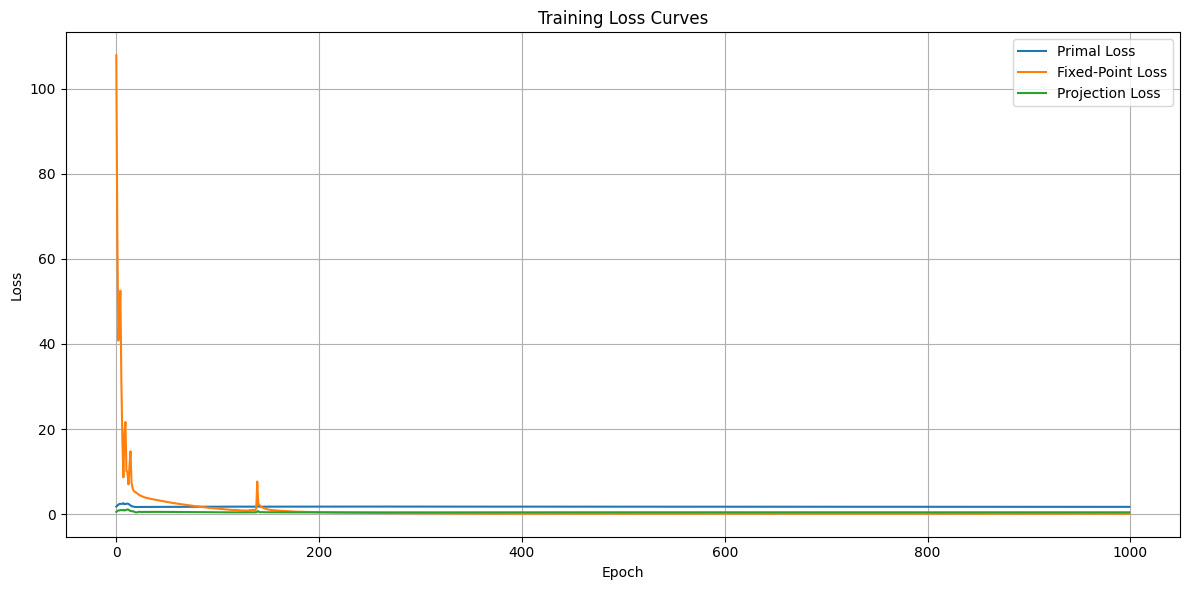

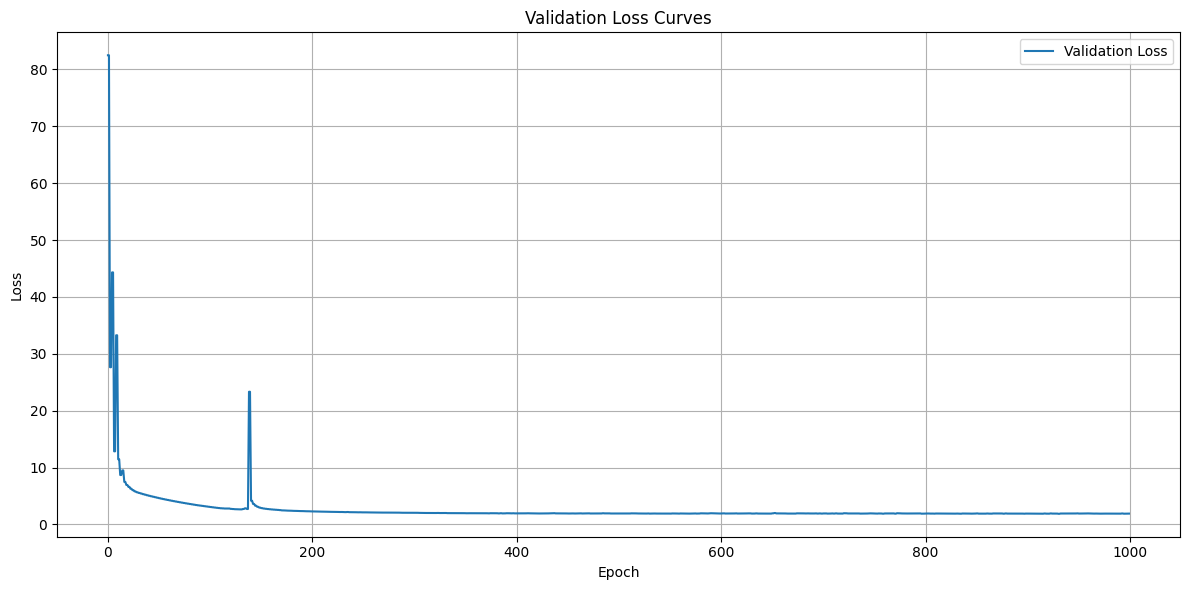

In [27]:
# Plot training losses

plt.figure(figsize=(12, 6))

#plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_projection_loss, label='Projection Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
avg_train_loss = np.asarray(avg_train_loss)
avg_val_loss = np.asarray(avg_val_loss)
print("Training_loss_end", avg_train_loss[-1])
print("Validation_loss_end", avg_val_loss[-1])

Training_loss_end 1.8544209
Validation_loss_end 1.8940408
